# VGGNet 16

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import os
import time

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    device = torch.device("cuda")  # GPU
    print(f"GPU mavjud: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")  # CPU
    print("GPU mavjud emas, CPU ishlatiladi.")
    
torch.cuda.empty_cache()   # Xotiradan bo‘shatish

GPU mavjud: NVIDIA GeForce RTX 3060


In [2]:
# Ma'lumotlarni oldindan qayta ishlash
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

# Ma'lumotlar to'plamini yuklash
train_dataset = datasets.ImageFolder(root="fer_2013_new/train", transform=transform)
test_dataset = datasets.ImageFolder(root="fer_2013_new/test", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [3]:
# Tayyor VGG-16 modelini yuklash va sozlash
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model.classifier[6] = nn.Linear(4096, 7)  # Chiqish qatlamini FER-2013 uchun moslashtirish
model = model.to(device)

In [4]:
# Yo'qotish funksiyasi va optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [5]:
# Modelni o'qitish funksiyasi
res_val_loss = []
res_val_acc = []
res_train_acc = []
res_train_loss = []

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20):
    best_val_acc = 0.0  # Eng yaxshi validation accuracy ni saqlash uchun
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / total_train
        train_accuracy = 100 * correct_train / total_train

        # Modelni baholash
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / total_val
        val_accuracy = 100 * correct_val / total_val

        # Natijalarni chiqarish
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        res_train_loss.append(train_loss)
        res_train_acc.append(train_accuracy)

        res_val_loss.append(val_loss)
        res_val_acc.append(val_accuracy)
        
        # Modelni saqlash
        torch.save(model.state_dict(), f"vgg16_fer2013_epoch{epoch+1}.pth")
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'vgg16_fer2013_best_model.pth')
            print(f"New best model saved with Val Accuracy: {best_val_acc:.2f}%")


In [6]:
# Modelni o'qitish yangisi
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)


Epoch 1/15, Train Loss: 1.3085, Train Accuracy: 50.44%, Val Loss: 1.0626, Val Accuracy: 60.88%
New best model saved with Val Accuracy: 60.88%
Epoch 2/15, Train Loss: 1.0333, Train Accuracy: 61.57%, Val Loss: 0.9739, Val Accuracy: 64.03%
New best model saved with Val Accuracy: 64.03%
Epoch 3/15, Train Loss: 0.9401, Train Accuracy: 65.18%, Val Loss: 0.9000, Val Accuracy: 66.16%
New best model saved with Val Accuracy: 66.16%
Epoch 4/15, Train Loss: 0.8755, Train Accuracy: 67.15%, Val Loss: 0.8706, Val Accuracy: 67.62%
New best model saved with Val Accuracy: 67.62%
Epoch 5/15, Train Loss: 0.8250, Train Accuracy: 69.37%, Val Loss: 0.8484, Val Accuracy: 68.30%
New best model saved with Val Accuracy: 68.30%
Epoch 6/15, Train Loss: 0.7824, Train Accuracy: 70.96%, Val Loss: 0.8187, Val Accuracy: 69.41%
New best model saved with Val Accuracy: 69.41%
Epoch 7/15, Train Loss: 0.7412, Train Accuracy: 72.68%, Val Loss: 0.8232, Val Accuracy: 69.71%
New best model saved with Val Accuracy: 69.71%
Epoch 

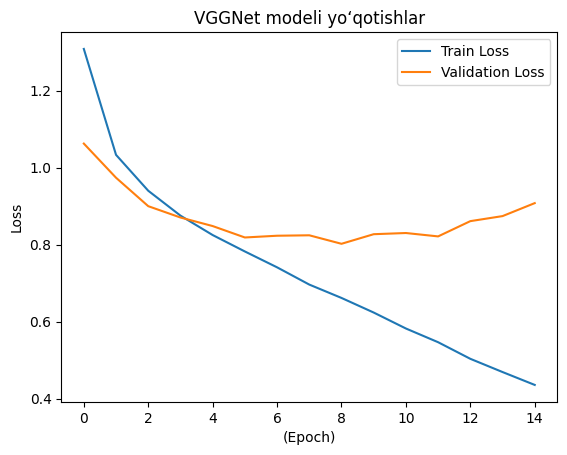

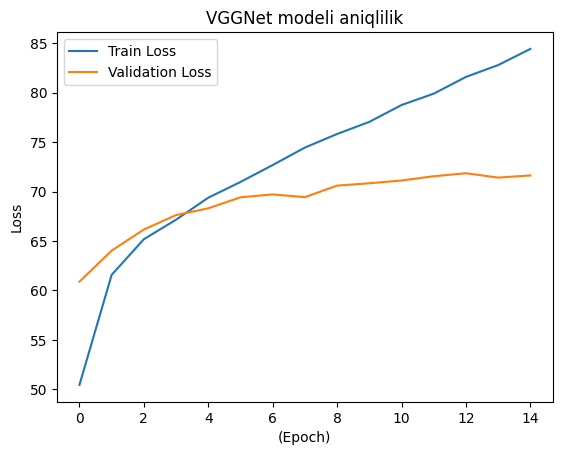

In [8]:

plt.plot(res_train_loss, label='Train Loss')
plt.plot(res_val_loss, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('VGGNet modeli yo‘qotishlar')
plt.show()

plt.plot(res_train_acc, label='Train Loss')
plt.plot(res_val_acc, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('VGGNet modeli aniqlilik')
plt.show()


In [6]:
# Modelni o'qitish
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=15)

Epoch 1/15, Train Loss: 1.2261, Train Accuracy: 53.54%, Val Loss: 1.0485, Val Accuracy: 60.42%
Epoch 2/15, Train Loss: 1.0005, Train Accuracy: 62.83%, Val Loss: 0.9332, Val Accuracy: 64.97%
Epoch 3/15, Train Loss: 0.9140, Train Accuracy: 65.85%, Val Loss: 0.9056, Val Accuracy: 65.42%
Epoch 4/15, Train Loss: 0.8486, Train Accuracy: 68.47%, Val Loss: 0.8810, Val Accuracy: 67.10%
Epoch 5/15, Train Loss: 0.7974, Train Accuracy: 70.34%, Val Loss: 0.8678, Val Accuracy: 66.87%
Epoch 6/15, Train Loss: 0.7527, Train Accuracy: 72.25%, Val Loss: 0.8206, Val Accuracy: 69.53%
Epoch 7/15, Train Loss: 0.7110, Train Accuracy: 73.59%, Val Loss: 0.8473, Val Accuracy: 69.71%
Epoch 8/15, Train Loss: 0.6757, Train Accuracy: 75.26%, Val Loss: 0.8457, Val Accuracy: 69.55%
Epoch 9/15, Train Loss: 0.6414, Train Accuracy: 76.45%, Val Loss: 0.8333, Val Accuracy: 70.29%
Epoch 10/15, Train Loss: 0.6001, Train Accuracy: 77.91%, Val Loss: 0.8645, Val Accuracy: 70.47%
Epoch 11/15, Train Loss: 0.5650, Train Accuracy: 

In [9]:
print(res_train_acc)
print(res_train_loss)
print("validatsiyani ikkalasi ham shunda ")
print(res_val_acc)


[1.2260862853515195, 1.0005387813989401, 0.9140033965631741, 0.84859368734938, 0.7973838274181979, 0.7527497133520152, 0.7110076450327574, 0.6757149872913781, 0.6413789120968642, 0.6000546015402294, 0.5649707408005826, 0.5279335336650638, 0.4945847919578027, 0.4660158519900481, 0.43082292333940175]
[1.2260862853515195, 1.0005387813989401, 0.9140033965631741, 0.84859368734938, 0.7973838274181979, 0.7527497133520152, 0.7110076450327574, 0.6757149872913781, 0.6413789120968642, 0.6000546015402294, 0.5649707408005826, 0.5279335336650638, 0.4945847919578027, 0.4660158519900481, 0.43082292333940175]
validatsiyani ikkalasi ham shunda 
[1.048484332461037, 60.42043714325491, 0.9332404237461537, 64.97285256856466, 0.9056124305389668, 65.41834887929835, 0.8810014084494596, 67.10288180426006, 0.8678312106829058, 66.8662118891828, 0.8205891556732041, 69.52526799387442, 0.8473253473250518, 69.70625087010998, 0.8457190128204358, 69.55311151329528, 0.833328334120643, 70.29096477794793, 0.86449324915697

In [10]:
vgg_train_loss = [1.2261,  1.0005,  0.9140,  0.8486,  0.7974,  0.7527,  0.7110,  0.6757,  0.6414,  0.6001,  0.5650,  0.5279,  0.4946,  0.4660,  0.4308]
vgg_train_acc = [53.54,  62.83,  65.85,  68.47,  70.34,  72.25,  73.59,  75.26,  76.45,  77.91,  79.29,  80.31,  81.84,  83.09,  84.19]
vgg_val_loss = [1.0485,  0.9332,  0.9056,  0.8810,  0.8678,  0.8206,  0.8473,  0.8457,  0.8333,  0.8645,  0.9054,  0.8893,  0.8874,  0.8904,  0.9517]
vgg_val_acc = [60.42, 64.97, 65.42, 67.10, 66.87, 69.53, 69.71, 69.55, 70.29, 70.47, 69.19, 70.18, 70.88, 70.86, 69.89]


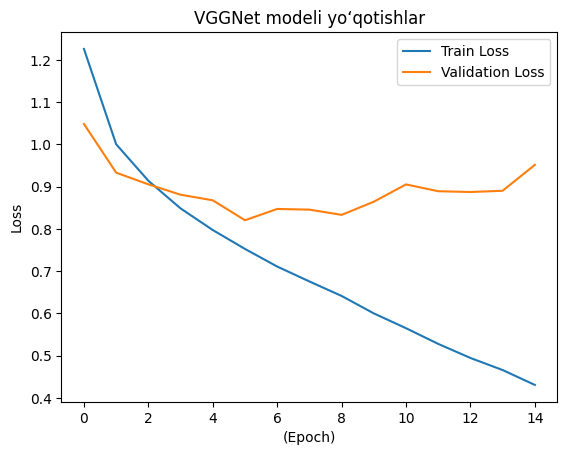

In [13]:
plt.plot(vgg_train_loss, label='Train Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('VGGNet modeli yo‘qotishlar')
plt.show()

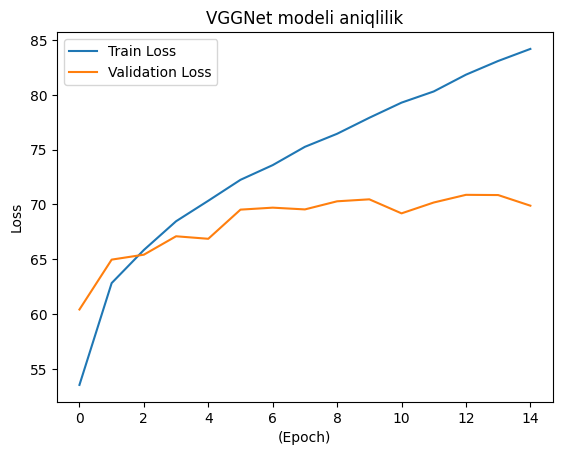

In [14]:
plt.plot(vgg_train_acc, label='Train Loss')
plt.plot(vgg_val_acc, label='Validation Loss')
plt.xlabel('(Epoch)')
plt.ylabel('Loss')
plt.legend()
plt.title('VGGNet modeli aniqlilik')
plt.show()